<a href="https://colab.research.google.com/github/w-rfrsh/leads-recommender/blob/master/leads_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Understending the problem

**Objective**

The purpose of this product is to provide an automated service that recommends leads to a user given their current customer list (Portfolio).

**Contextualization**

Some companies would like to know who are the other companies in a given market (population) that are most likely to become their next customers. That is, your solution must find in the market who are the most adherent leads given the characteristics of the customers present in the user's portfolio.

In addition, your solution must be user agnostic. Any user with a list of customers who want to explore this market can extract value from the service.

For the challenge, the following bases should be considered:

> Market: Base with information about the companies in the market to be  considered. 

> Portfolio 1: Company customer ids 1

> Portfolio 2: Company customer ids 2

> Portfolio 3: Company customer ids 3

Note: all companies (ids) in the portfolios are contained in the Market (population base).

Link to download the Market, Portfolio 1, Portfolio 2 and Portfolio 3 bases respectively:

# General setup

## Imports

In [1]:
#Importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Datasets

In [2]:
#Mounting at Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Reading main dataframe
raw_market = pd.read_csv('gdrive/My Drive/Leads Recommender/data/estaticos_market.csv', index_col='id')

In [4]:
#Showing the main df
market = raw_market.copy().drop(columns = 'Unnamed: 0')
market.head()

,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,dt_situacao,fl_st_especial,fl_email,fl_telefone,fl_rm,nm_divisao,nm_segmento,fl_spa,fl_antt,fl_veiculo,vl_total_tancagem,vl_total_veiculos_antt,vl_total_veiculos_leves,vl_total_veiculos_pesados,fl_optante_simples,qt_art,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,vl_total_tancagem_grupo,vl_total_veiculos_antt_grupo,vl_potenc_cons_oleo_gas,fl_optante_simei,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,nu_meses_rescencia,de_nivel_atividade,...,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_ex_funcionarios,qt_funcionarios_grupo,percent_func_genero_masc,percent_func_genero_fem,idade_ate_18,idade_de_19_a_23,idade_de_24_a_28,idade_de_29_a_33,idade_de_34_a_38,idade_de_39_a_43,idade_de_44_a_48,idade_de_49_a_53,idade_de_54_a_58,idade_acima_de_58,grau_instrucao_macro_analfabeto,grau_instrucao_macro_escolaridade_fundamental,grau_instrucao_macro_escolaridade_media,grau_instrucao_macro_escolaridade_superior,grau_instrucao_macro_desconhecido,total,meses_ultima_contratacaco,qt_admitidos_12meses,qt_desligados_12meses,qt_desligados,qt_admitidos,media_meses_servicos_all,max_meses_servicos_all,min_meses_servicos_all,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,False,False,False,False,False,2005-03-25,False,True,True,SIM,CONSTRUCAO DE EDIFICIOS,CONSTRUCAO,False,False,False,NaN,NaN,NaN,NaN,True,8.0,0.0,0.0,NaN,NaN,NaN,False,RN,VERDE,ACIMA DE 1 ANO,23.0,ALTA,...,3132172.8,3132172.8,119.0,26.0,100.0,0.0,NaN,1.0,4.0,6.0,5.0,3.0,4.0,2.0,NaN,1.0,NaN,1.0,25.0,NaN,NaN,26.0,19.166667,0.0,0.0,119.0,145.0,13.309195,93.266667,-0.933333,43.738462,93.266667,19.166667,26.0,26.0,27.0,0.0,-3.703704,0.0,0
6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c47fdef50b33f4f56f05,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,1 a 5,False,False,False,True,False,2017-05-12,False,True,True,SIM,ALIMENTACAO,ALOJAMENTO E ALIMENTACAO,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,PI,CINZA,ATE 1 ANO,9.0,BAIXA,...,210000.0,210000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02edc5147bc2a2535b08,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,"TRANSPORTE, ARMAZENAGEM E CORREIO",SERVIÇO,7.093151,5 a 10,False,False,False,True,False,2011-09-26,False,False,True,SIM,TRANSPORTE TERRESTRE,TRANSPORTE ARMAZENAGEM E CORREIO,False,False,False,NaN,NaN,NaN,NaN,True,NaN,0.0,0.0,NaN,NaN,NaN,True,AM,AMARELO,ACIMA DE 1 ANO,26.0,MEDIA,...,50000.0,50000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3348900fe63216a439d2e5238c79ddd46ede454df7b9d8c24ac33eb21d4b21ef,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,SERVICOS DIVERSOS,SERVIÇO,6.512329,5 a 10,False,False,False,False,False,2012-04-25,False,True,True,SIM,REPARACAO E MANUTENCAO DE EQUIPAMENTOS DE INFO...,OUTRAS ATIVIDADES DE SERVICOS,False,False,False,NaN,NaN,NaN,NaN,True,NaN,0.0,0.0,NaN,NaN,NaN,False,AM,AMARELO,ACIMA DE 1 ANO,26.0,MEDIA,...,210000.0,210000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4b102c769f7611ab29f,True,EMPRESARIO INDIVIDUAL,RN,OUTROS,"SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",SERVIÇO,3.

In [0]:
#Reading portfolios
raw_portfolio1 = pd.read_csv('gdrive/My Drive/Leads Recommender/data/estaticos_portfolio1.csv', index_col='id').drop(columns = 'Unnamed: 0')
raw_portfolio2 = pd.read_csv('gdrive/My Drive/Leads Recommender/data/estaticos_portfolio2.csv', index_col='id').drop(columns = 'Unnamed: 0')
raw_portfolio3 = pd.read_csv('gdrive/My Drive/Leads Recommender/data/estaticos_portfolio3.csv', index_col='id').drop(columns = 'Unnamed: 0')

# Exploratory Data Analysis and Data Muning

### Usefull functions

In [0]:
def drop_col(df, col):
  try:
    df.drop(columns = col, inplace=True)
  except:
    print(f'The column {col} does not exist or has lready been removed.')

In [0]:
def encode(df):
  categorical_columns = df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
  numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

  df_processed = pd.get_dummies(data=df, columns=categorical_columns)

  scaler = MinMaxScaler()
  scaled_data = scaler.fit_transform(df[numerical_columns])
  df_processed[numerical_columns] = scaled_data

  return df_processed

### Feature selection

**In this section, we will analyse the behavior of the features and select wich are usefull to the model.**

---



First of all, we must analyse the distribution of missing values of the main dataset.

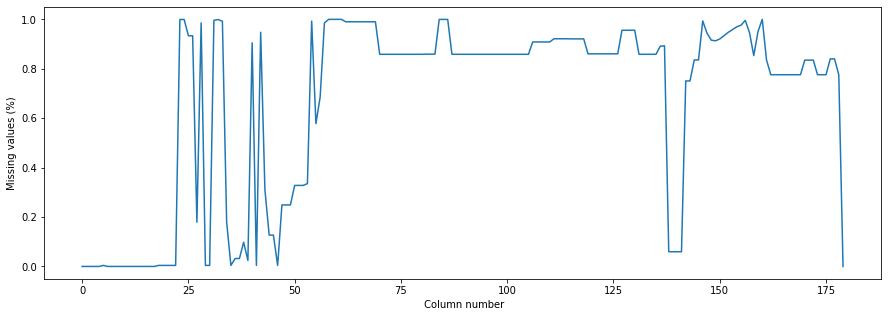

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=range(0, market.shape[1]), y=market.isnull().mean())
ax.set(xlabel=' Column number', ylabel='Missing values (%)')
plt.show()

As we can see, several columns have most of their values as missing. Therefore, let's remove them, taking the 67% threshold as the minimum of non-missing data in a given variable.

In [0]:
threshold = 0.70
market =  market.loc[:, market.notnull().mean() > threshold]

---
The recommendation we seek is independent of whether it is a parent company or not. Thus, the ```fl_matriz``` column  does not have relevance to our model, let's drop it.


In [0]:
drop_col(market, 'fl_matriz')

----
Now we are going to take a look at ```natureza_juridica_macro``` and ```de_natureza_juridica```.

In [11]:
print(market['natureza_juridica_macro'].value_counts())

OUTROS                            320211
ENTIDADES EMPRESARIAIS             99241
ENTIDADES SEM FINS LUCRATIVOS      37089
ADMINISTRACAO PUBLICA               2912
CARGO POLITICO                      1617
PESSOAS FISICAS                     1225
INSTITUICOES EXTRATERRITORIAIS         3
Name: natureza_juridica_macro, dtype: int64


In [12]:
print(market['de_natureza_juridica'].value_counts())

EMPRESARIO INDIVIDUAL                                                     295756
SOCIEDADE EMPRESARIA LIMITADA                                              91231
ASSOCIACAO PRIVADA                                                         29694
EMPRESA INDIVIDUAL DE RESPONSABILIDADE LIMITADA DE NATUREZA EMPRESARIA     15183
ORGAO DE DIRECAO LOCAL DE PARTIDO POLITICO                                  7301
                                                                           ...  
SOCIEDADE SIMPLES EM NOME COLETIVO                                             1
CONSORCIO PUBLICO DE DIREITO PRIVADO                                           1
FUNDO PRIVADO                                                                  1
CONSORCIO DE EMPREGADORES                                                      1
ORGAO DE DIRECAO NACIONAL DE PARTIDO POLITICO                                  1
Name: de_natureza_juridica, Length: 67, dtype: int64


It is noticeable that ```de_natureza_juridica``` describe the same as ```natureza_juridica_macro```, but in more detail. That said, in order to become more general, we can drop the specificist column.

In [0]:
drop_col(market, 'de_natureza_juridica')

---
Let's inspect now ```setor```, ```nm_divisao```, ```nm_segmento``` and ```de_ramo```.

In [14]:
print(market['setor'].value_counts())

COMERCIO            211224
SERVIÇO             189644
INDUSTRIA            30893
CONSTRUÇÃO CIVIL     25363
AGROPECUARIA          3247
Name: setor, dtype: int64


In [15]:
print(market['de_ramo'].value_counts())

COMERCIO VAREJISTA                                   172404
SERVICOS DIVERSOS                                     60318
SERVICOS DE ALOJAMENTO/ALIMENTACAO                    30180
INDUSTRIA DA CONSTRUCAO                               25363
COMERCIO E REPARACAO DE VEICULOS                      22356
SERVICOS ADMINISTRATIVOS                              21326
BENS DE CONSUMO                                       21227
SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS        17371
COMERCIO POR ATACADO                                  16464
TRANSPORTE, ARMAZENAGEM E CORREIO                     15485
SERVICOS DE EDUCACAO                                  11311
SERVICOS DE SAUDE                                      9788
CULTURA, ESPORTE E RECREACAO                           5503
SIDERURGICA-METALURGIA                                 3700
TELECOM                                                3626
PRODUTOS DE AGROPECUARIA                               3247
QUIMICA-PETROQUIMICA                    

In [16]:
print(market['nm_divisao'].value_counts())

COMERCIO VAREJISTA                                                   172404
ATIVIDADES DE ORGANIZACOES ASSOCIATIVAS                               37984
ALIMENTACAO                                                           27540
COMERCIO E REPARACAO DE VEICULOS AUTOMOTORES E MOTOCICLETAS           22356
COMERCIO POR ATACADO EXCETO VEICULOS AUTOMOTORES E MOTOCICLETAS       16464
                                                                      ...  
FABRICACAO DE PRODUTOS FARMOQUIMICOS E FARMACEUTICOS                     22
DESCONTAMINACAO E OUTROS SERVICOS DE GESTAO DE RESIDUOS                  12
ORGANISMOS INTERNACIONAIS E OUTRAS INSTITUICOES EXTRATERRITORIAIS         9
FABRICACAO DE PRODUTOS DO FUMO                                            2
EXTRACAO DE CARVAO MINERAL                                                1
Name: nm_divisao, Length: 87, dtype: int64


In [17]:
print(market['nm_segmento'].value_counts())

COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E MOTOCICLETAS           211224
OUTRAS ATIVIDADES DE SERVICOS                                         59561
INDUSTRIAS DE TRANSFORMACAO                                           31968
ALOJAMENTO E ALIMENTACAO                                              30180
CONSTRUCAO                                                            25363
ATIVIDADES ADMINISTRATIVAS E SERVICOS COMPLEMENTARES                  21326
ATIVIDADES PROFISSIONAIS CIENTIFICAS E TECNICAS                       17371
TRANSPORTE ARMAZENAGEM E CORREIO                                      15485
EDUCACAO                                                              11311
SAUDE HUMANA E SERVICOS SOCIAIS                                       10139
ARTES CULTURA ESPORTE E RECREACAO                                      5503
INFORMACAO E COMUNICACAO                                               5475
ATIVIDADES FINANCEIRAS DE SEGUROS E SERVICOS RELACIONADOS              3287
AGRICULTURA 

As before, here we have some variables that differ in the degree of specificity. We will remain with a intermediate one, ```nm_segmento``` sounds a good choice.

In [19]:
drop_col(market, 'setor')
drop_col(market, 'de_ramo')
drop_col(market, 'nm_divisao')

The column setor does not exist or has lready been removed.
The column de_ramo does not exist or has lready been removed.
The column nm_divisao does not exist or has lready been removed.


---
The next ones to be analysed is ```idade_empresa_anos``` and ```idade_emp_cat```.

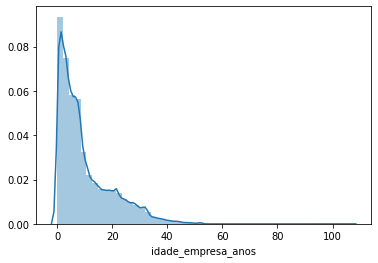

In [20]:
fig, axes = plt.subplots()
sns.distplot(market['idade_empresa_anos'])

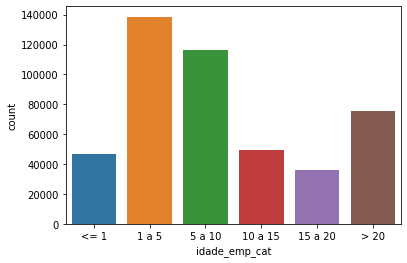

In [21]:
sns.countplot(market['idade_emp_cat'], order=['<= 1','1 a 5', '5 a 10', '10 a 15', '15 a 20', '> 20'])

To avoid a increase the dimensionality of our data, let's choose ```idade_empresas_anos``` to work with.

In [0]:
drop_col(market, 'idade_emp_cat')

---
The following variables tell us, primarily about the name of the companies and, in a second level, about the size of it. Although the second information may be relevant, there are other variables in the dataset that are better for this purpose.

In [0]:
drop_col(market, 'fl_me')
drop_col(market, 'fl_sa')
drop_col(market, 'fl_epp')
drop_col(market, 'fl_mei')
drop_col(market, 'fl_ltda')

----
To our purpose, information about a possible extraordinary situation is identified by the IRS is not relevant. Thus, we will drop ```dt_situacao``` and ```fl_st_especial```.

In [0]:
drop_col(market, 'dt_situacao')
drop_col(market, 'fl_st_especial')

The next one is about if the companies performs any activity that is taxable under ISS and, also, is not relevant. 

In [0]:
drop_col(market, 'fl_passivel_iss')


In addition, ```fl_email``` and ```fl__telefone``` are not relevant because they just tell us about if there is a email or phone number registred in IRS database.

In [0]:
drop_col(market, 'fl_email')
drop_col(market, 'fl_telefone')

---
Now, let's take a look at ```fl_spa```, ```fl_ant```, ```fl_veiculo```, ```vl_total_veiculos_leves_grupo``` and ```vl_total_veiculos_pesados_grupo```.

In [27]:
print(market['fl_spa'].value_counts())

False    460091
True        280
Name: fl_spa, dtype: int64


In [28]:
print(market['fl_antt'].value_counts())

False    457095
True       3276
Name: fl_antt, dtype: int64


In [29]:
print(market['fl_veiculo'].value_counts())

False    429687
True      30684
Name: fl_veiculo, dtype: int64


In [30]:
print(market['vl_total_veiculos_leves_grupo'].value_counts())

0.0       424180
1.0        15738
2.0         5232
3.0         2610
4.0         1569
           ...  
601.0          1
353.0          1
9713.0         1
229.0          1
218.0          1
Name: vl_total_veiculos_leves_grupo, Length: 310, dtype: int64


In [31]:
print(market['vl_total_veiculos_pesados_grupo'].value_counts())

0.0       441360
1.0         6785
2.0         2585
3.0         1301
4.0          827
           ...  
136.0          1
681.0          1
341.0          1
191.0          1
1495.0         1
Name: vl_total_veiculos_pesados_grupo, Length: 296, dtype: int64


We will drop all five variables because they have at least 90% of the distribution as a single value.

In [0]:
drop_col(market, 'fl_spa')
drop_col(market, 'fl_antt')
drop_col(market, 'fl_veiculo')
drop_col(market, 'vl_total_veiculos_leves_grupo')
drop_col(market, 'vl_total_veiculos_pesados_grupo')

----
The following variables deal with the company's financial health and the date of the last update of this item.For our purpose, they are disposable.


In [0]:
drop_col(market, 'de_saude_tributaria')
drop_col(market, 'de_saude_rescencia')
drop_col(market, 'nu_meses_rescencia')

---
Let's take a look at ```nm_meso_regiao``` ,```nm_micro_regiao``` and ```sg_uf```.

In [34]:
print(market['nm_meso_regiao'].value_counts())

CENTRO AMAZONENSE         71469
NORTE MARANHENSE          61331
LESTE POTIGUAR            58762
CENTRO NORTE PIAUIENSE    42244
OESTE MARANHENSE          26796
OESTE POTIGUAR            20860
LESTE MARANHENSE          17651
VALE DO ACRE              16539
CENTRO MARANHENSE         13755
SUDOESTE PIAUIENSE        12180
NORTE PIAUIENSE           11919
CENTRAL POTIGUAR          10681
SUDESTE PIAUIENSE         10049
AGRESTE POTIGUAR           7845
SUL MARANHENSE             7382
SUL AMAZONENSE             4931
VALE DO JURUA              3900
SUDOESTE AMAZONENSE        3738
NORTE AMAZONENSE           1568
Name: nm_meso_regiao, dtype: int64


In [35]:
print(market['nm_micro_regiao'].value_counts())

MANAUS                            60008
NATAL                             46745
AGLOMERACAO URBANA DE SAO LUIS    45875
TERESINA                          33887
IMPERATRIZ                        15912
                                  ...  
BERTOLINIA                          854
PIO IX                              823
PURUS                               757
MEDIO OESTE                         562
JAPURA                              190
Name: nm_micro_regiao, Length: 73, dtype: int64


In [36]:
print(market['sg_uf'].value_counts())

MA    127654
RN     98837
AM     82114
PI     76686
RO     56469
AC     20538
Name: sg_uf, dtype: int64


As has already happened, here we have the case of variables that deal strictly with the same issue (location), but with different degrees of specificity. Let's stay with the most generalist, which is the ```sg_uf```.

In [0]:
drop_col(market, 'nm_meso_regiao')
drop_col(market, 'nm_micro_regiao')

---
All of the variables below inform us about the company's partners. This kind of data is irrelevant, let's drop these columns.

In [0]:
drop_col(market, 'qt_socios')
drop_col(market, 'qt_socios_pf')
drop_col(market, 'qt_socios_pj')

---
Here we have another group of variables to be analyzed: ```vl_faturamento_estimado_grupo_aux``` and  ```de_faixa_faturamento_estimado_grupo```.

As we want to recommend leads, data about the group in which a company belongs is not important to us. Let's drop ```vl_faturamento_estimado_grupo_aux```,  ```de_faixa_faturamento_estimado_grupo``` and ```sg_uf_matriz```.

In [0]:
drop_col(market, 'vl_faturamento_estimado_grupo_aux')
drop_col(market, 'de_faixa_faturamento_estimado_grupo')
drop_col(market, 'sg_uf_matriz')

---
Now, let's see ```vl_faturamento_estimado_aux``` and ```de_faixa_faturamento_estimado```.

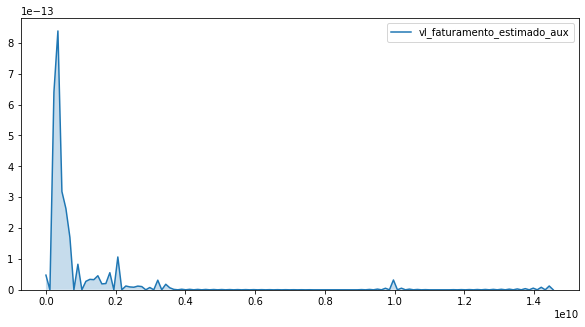

In [40]:
fig, axes = plt.subplots(figsize=(10, 5))
sns.kdeplot(market['vl_faturamento_estimado_aux'], shade=True)

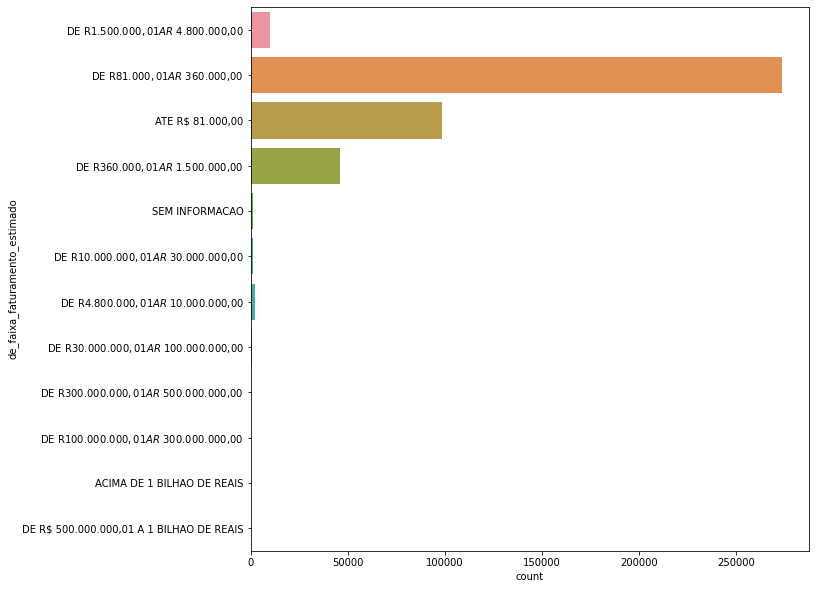

In [41]:
fig, axes = plt.subplots(figsize=(10, 10))
sns.countplot(y=market['de_faixa_faturamento_estimado'])

The two variables previously plotted are the same thing, ```de_faixa_faturamento_estimado``` being a categorical version of ```vl_faturamento_estimado_aux```. In order not to increase the dimensionality, we will keep the numeric one.

In [0]:
drop_col(market, 'de_faixa_faturamento_estimado')

---
The ```qt_filiais``` column have a low variance, because approximately
90% of companies have 0 subsidiaries.

In [43]:
print(market['qt_filiais'].value_counts())

0      418043
1       19561
2        5943
3        2884
4        1772
        ...  
173         1
148         1
209         1
215         1
404         1
Name: qt_filiais, Length: 304, dtype: int64


Thus, let's drop it.

In [0]:
drop_col(market, 'qt_filiais')

---
The following variables are about the company's tax regime and this information is irrelevant to the problem in question.

In [0]:
drop_col(market, 'fl_optante_simei')
drop_col(market, 'fl_optante_simples')
drop_col(market, 'fl_simples_irregular')

---
The probability of company being operating is irrelevant by now, so we can drop```de_nivel_atividade```.

In [0]:
drop_col(market, 'de_nivel_atividade')